In [7]:
!pip install -q -r requirements.txt


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib

In [13]:
X_train = np.load('../artifacts/X_train.npz')['arr_0']
Y_train = np.load('../artifacts/Y_train.npz')['arr_0']
X_test = np.load('../artifacts/X_test.npz')['arr_0']
Y_test = np.load('../artifacts/Y_test.npz')['arr_0']

=== Random Forest ===
Accuracy : 0.7686
Precision: 0.5517
Recall   : 0.6845
F1-Score : 0.6110


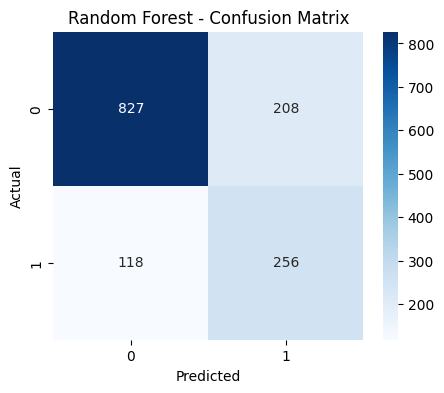

['../JoblibModels/random_forest.pkl']

In [14]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42
)

rf.fit(X_train, Y_train)

# Predictions
Y_hat_train_rf = rf.predict(X_train)
Y_hat_test_rf = rf.predict(X_test)
Y_proba_train_rf = rf.predict_proba(X_train)
Y_proba_test_rf = rf.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(Y_test, Y_hat_test_rf)
precision = precision_score(Y_test, Y_hat_test_rf)
recall = recall_score(Y_test, Y_hat_test_rf)
f1 = f1_score(Y_test, Y_hat_test_rf)

print("=== Random Forest ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_hat_test_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(rf, "../JoblibModels/random_forest.pkl")



=== XGBoost ===
Accuracy : 0.7793
Precision: 0.5831
Recall   : 0.5909
F1-Score : 0.5870


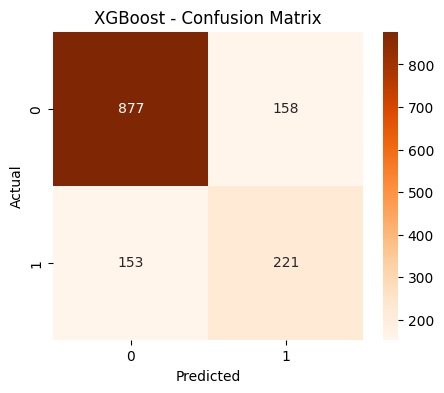

['../JoblibModels/xgboost.pkl']

In [16]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
   
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, Y_train)

Y_hat_test_xgb = xgb.predict(X_test)

accuracy = accuracy_score(Y_test, Y_hat_test_xgb)
precision = precision_score(Y_test, Y_hat_test_xgb)
recall = recall_score(Y_test, Y_hat_test_xgb)
f1 = f1_score(Y_test, Y_hat_test_xgb)

print("\n=== XGBoost ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

cm = confusion_matrix(Y_test, Y_hat_test_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(xgb, "../JoblibModels/xgboost.pkl")



=== CatBoost ===
Accuracy : 0.7835
Precision: 0.5906
Recall   : 0.6016
F1-Score : 0.5960


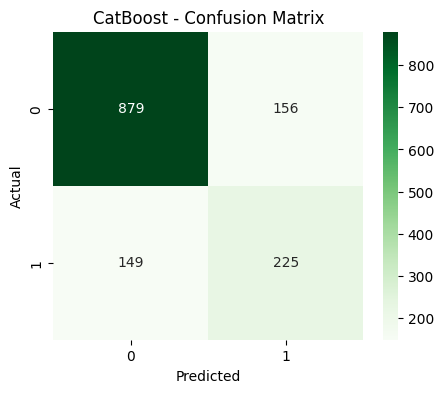

['../JoblibModels/catboost.pkl']

In [17]:
cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_state=42
)

cat.fit(X_train, Y_train)

Y_hat_test_cat = cat.predict(X_test)

accuracy = accuracy_score(Y_test, Y_hat_test_cat)
precision = precision_score(Y_test, Y_hat_test_cat)
recall = recall_score(Y_test, Y_hat_test_cat)
f1 = f1_score(Y_test, Y_hat_test_cat)

print("\n=== CatBoost ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

cm = confusion_matrix(Y_test, Y_hat_test_cat)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("CatBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(cat, "../JoblibModels/catboost.pkl")

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def kfold_evaluation(model, X, Y):
    acc, f1s, recalls, precisions, roc_aucs = [], [], [], [], []
    
    for train_idx, val_idx in kfold.split(X, Y):
        X_tr, X_val = X[train_idx], X[val_idx]   # NumPy indexing
        Y_tr, Y_val = Y[train_idx], Y[val_idx]
        
        model.fit(X_tr, Y_tr)
        Y_pred = model.predict(X_val)
        acc.append(accuracy_score(Y_val, Y_pred))
        f1s.append(f1_score(Y_val, Y_pred))
        recalls.append(recall_score(Y_val, Y_pred))
        precisions.append(precision_score(Y_val, Y_pred))
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_val)[:,1]
            roc_aucs.append(roc_auc_score(Y_val, probs))
    
    print(f"Accuracy : {np.mean(acc):.4f}")
    print(f"F1-Score : {np.mean(f1s):.4f}")
    print(f"Recall   : {np.mean(recalls):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    if roc_aucs:
        print(f"ROC-AUC  : {np.mean(roc_aucs):.4f}")

In [20]:
print("Random Forrest Validation Metrics: \n")
kfold_evaluation(rf, X_train, Y_train)

print("\nXgboost Classifier Validation: \n")
kfold_evaluation(xgb, X_train, Y_train)

print("\nCat Boost Validation: \n")
kfold_evaluation(cat, X_train, Y_train)

Random Forrest Validation Metrics: 

Accuracy : 0.8409
F1-Score : 0.8461
Recall   : 0.8751
Precision: 0.8192
ROC-AUC  : 0.9144

Xgboost Classifier Validation: 

Accuracy : 0.8617
F1-Score : 0.8613
Recall   : 0.8587
Precision: 0.8640
ROC-AUC  : 0.9383

Cat Boost Validation: 

Accuracy : 0.8581
F1-Score : 0.8573
Recall   : 0.8526
Precision: 0.8622
ROC-AUC  : 0.9377


In [ ]:
# Logistic Regression
lr = joblib.load('../JoblibModels/logistic_regression_base.pkl')
Y_hat_test_lr = lr.predict(X_test)
Y_proba_test_lr = lr.predict_proba(X_test)

# Decision Tree
dt = joblib.load('../JoblibModels/DecisionTree_base.pkl')  
Y_hat_test_dt = dt.predict(X_test)
Y_proba_test_dt = dt.predict_proba(X_test)

In [35]:
# XGBoost
Y_hat_test_xgb = xgb.predict(X_test)
Y_proba_test_xgb = xgb.predict_proba(X_test) 

# CatBoost
Y_hat_test_cat = cat.predict(X_test)
Y_proba_test_cat = cat.predict_proba(X_test) 


In [38]:
Y_hat_tests = {
    'Logistic Regression': Y_hat_test_lr,
    'Decision Tree': Y_hat_test_dt,
    'Random Forest': Y_hat_test_rf,
    'XGBoost': Y_hat_test_xgb,
    'CatBoost': Y_hat_test_cat
}

# If you have probabilities for ROC-AUC
Y_proba_tests = {
    'Logistic Regression': Y_proba_test_lr[:,1],
    'Decision Tree': Y_proba_test_dt[:,1],
    'Random Forest': Y_proba_test_rf[:,1],
    'XGBoost': Y_proba_test_xgb[:,1],
    'CatBoost': Y_proba_test_cat[:,1]
}

metrics_list = []
for name, preds in Y_hat_tests.items():
    acc = accuracy_score(Y_test, preds)
    prec = precision_score(Y_test, preds)
    rec = recall_score(Y_test, preds)
    f1 = f1_score(Y_test, preds)
    roc = roc_auc_score(Y_test, Y_proba_tests[name])
    
    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.738112,0.504288,0.786096,0.614420,0.839629
1,Decision Tree,0.732434,0.496314,0.540107,0.517286,0.670797
2,Random Forest,0.768630,0.551724,0.684492,0.610979,0.836052
3,XGBoost,0.777857,0.584958,0.561497,0.572988,0.826512
4,CatBoost,0.780696,0.587601,0.582888,0.585235,0.836533


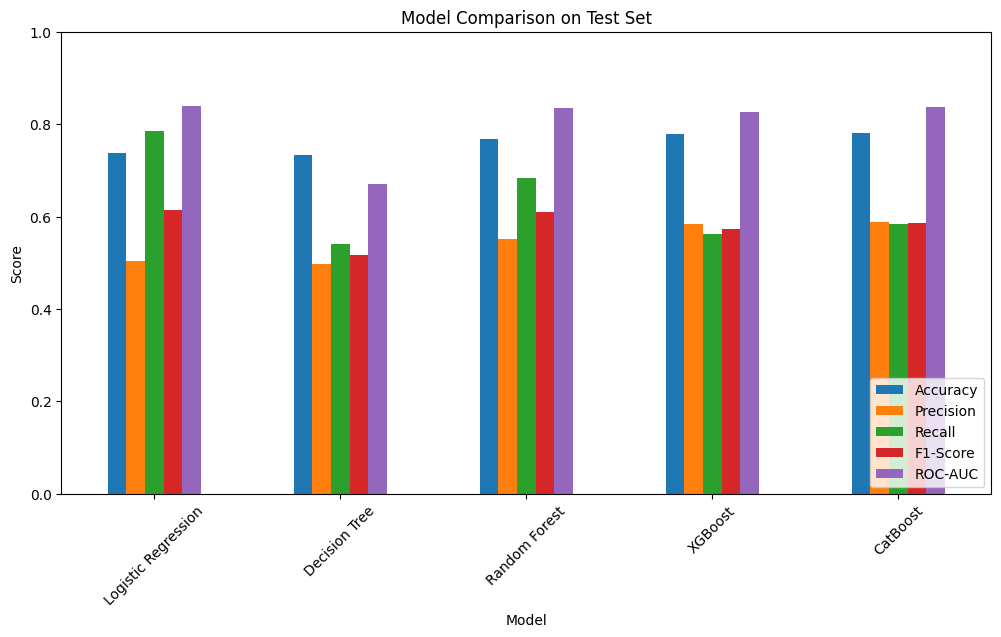

In [39]:

df_metrics.set_index('Model', inplace=True)
df_metrics.plot(kind='bar', figsize=(12,6))
plt.title('Model Comparison on Test Set')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

In [40]:
metrics_list = []
for name, preds in Y_hat_tests.items():
    acc = accuracy_score(Y_test, preds)
    prec = precision_score(Y_test, preds)
    rec = recall_score(Y_test, preds)
    f1 = f1_score(Y_test, preds)
    roc = roc_auc_score(Y_test, Y_proba_tests[name])
    
    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

# Create DataFrame for comparison
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.sort_values(by='F1-Score', ascending=False)  # sort by F1
df_metrics

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.738112,0.504288,0.786096,0.614420,0.839629
2,Random Forest,0.768630,0.551724,0.684492,0.610979,0.836052
4,CatBoost,0.780696,0.587601,0.582888,0.585235,0.836533
3,XGBoost,0.777857,0.584958,0.561497,0.572988,0.826512
1,Decision Tree,0.732434,0.496314,0.540107,0.517286,0.670797


In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score


xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
   
    random_state=42
)

# Hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

# Use F1-score for imbalanced classification
f1_scorer = make_scorer(f1_score)

# RandomizedSearchCV
xgb_cv = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid_xgb,
    scoring=f1_scorer,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_cv.fit(X_train, Y_train)

# Best parameters
print("Best XGBoost parameters:", xgb_cv.best_params_)

# Predictions
Y_hat_test_xgb = xgb_cv.predict(X_test)
Y_proba_test_xgb = xgb_cv.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [46]:
from catboost import CatBoostClassifier

# Define model
cat = CatBoostClassifier(
    random_state=42,
    eval_metric='F1',
    verbose=0
)

# Hyperparameter grid
param_grid_cat = {
    'iterations': [200, 400, 600],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# RandomizedSearchCV
cat_cv = RandomizedSearchCV(
    cat,
    param_distributions=param_grid_cat,
    scoring=f1_scorer,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

cat_cv.fit(X_train, Y_train)

# Best parameters
print("Best CatBoost parameters:", cat_cv.best_params_)

# Predictions
Y_hat_test_cat = cat_cv.predict(X_test)
Y_proba_test_cat = cat_cv.predict_proba(X_test)[:,1]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 8, 'border_count': 64}


In [48]:
Y_hat_tests = {
    'Logistic Regression': Y_hat_test_lr,
    'Decision Tree': Y_hat_test_dt,
    'Random Forest': Y_hat_test_rf,
    'XGBoost': Y_hat_test_xgb,
    'CatBoost': Y_hat_test_cat
}

# If you have probabilities for ROC-AUC
Y_proba_tests = {
    'Logistic Regression': Y_proba_test_lr[:,1],
    'Decision Tree': Y_proba_test_dt[:,1],
    'Random Forest': Y_proba_test_rf[:,1],
    'XGBoost': Y_proba_test_xgb,
    'CatBoost': Y_proba_test_cat
}

metrics_list = []
for name, preds in Y_hat_tests.items():
    acc = accuracy_score(Y_test, preds)
    prec = precision_score(Y_test, preds)
    rec = recall_score(Y_test, preds)
    f1 = f1_score(Y_test, preds)
    roc = roc_auc_score(Y_test, Y_proba_tests[name])
    
    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.738112,0.504288,0.786096,0.614420,0.839629
1,Decision Tree,0.732434,0.496314,0.540107,0.517286,0.670797
2,Random Forest,0.768630,0.551724,0.684492,0.610979,0.836052
3,XGBoost,0.770759,0.560859,0.628342,0.592686,0.837482
4,CatBoost,0.770050,0.557078,0.652406,0.600985,0.839886
